In [1]:
cd ..

C:\Users\user\Documents\dton-wildfires-cleaner


In [2]:
import os
from datetime import timedelta

from sentinelhub import SHConfig, DataCollection
from sentinelhub.time_utils import iso_to_datetime
import matplotlib.pyplot as plt

from utils import get_env_var
from event_registry_utils import EventRegistry
from events_utils import filter_events_by_concept_thresholds, get_locations_from_concepts
from processing.date_utils import get_exact_date, start_of_day, end_of_day
from processing.bbox_utils import create_bbox
from processing.evalscripts import wildfire_detection
from processing.fetching_utils import get_image
from processing.pinpoint_location import get_bbox

In [3]:
EVENT_REGISTRY_API_KEY = get_env_var("EVENT_REGISTRY_API_KEY")

In [4]:
event_registry = EventRegistry(EVENT_REGISTRY_API_KEY)

In [5]:
date_start = "2020-01-01"
date_end = "2021-01-01"

In [6]:
# THIS CELL CAN BE IGNORED, JUST SETTING UP
INSTANCE_ID = os.environ['INSTANCE_ID']
CLIENT_ID = os.environ['CLIENT_ID']
CLIENT_SECRET = os.environ['CLIENT_SECRET']

config = SHConfig()
config.instance_id = INSTANCE_ID
config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

# Taken from the notebook for volcano query
query = {
    "$query": {
        "$and": [
            {
                "$and": [
                    {
                        "conceptUri": "http://en.wikipedia.org/wiki/Volcano"
                    },
                    {
                        "$or": [
                            {
                                "conceptUri": "http://en.wikipedia.org/wiki/Types_of_volcanic_eruptions"
                            },
                            {
                                "conceptUri": "http://en.wikipedia.org/wiki/Volcanic_ash"
                            }
                        ]
                    }
                    
                ]
            },
            {
                "dateStart": date_start,
                "dateEnd": date_end,
            },
            {
                "lang": "eng"
            }
        ], 
        "$not": {
            "$or": [
                {
                    "conceptUri": "http://en.wikipedia.org/wiki/Archaeology"
                },
                {
                    "conceptUri": "http://en.wikipedia.org/wiki/Rock_(geology)"
                },
                {
                    "conceptUri": "http://en.wikipedia.org/wiki/Hotspot_(geology)"
                },
                {
                    "conceptUri": "http://en.wikipedia.org/wiki/Supervolcano"
                },
                {
                    "conceptUri": "http://en.wikipedia.org/wiki/Tourism"
                },
                {
                    "conceptUri": "http://en.wikipedia.org/wiki/Lahar"
                }
            ]
        }
    }
}
events = event_registry.get_events_from_media_intelligence(query, include_event_concepts=True)
thresholds = [
    {
        'uri': 'http://en.wikipedia.org/wiki/Volcano',
        'score_threshold': 90
    },
    {
        'uri': 'http://en.wikipedia.org/wiki/Volcanic_ash',
        'score_threshold': 50,
        'allow_not_exist': True
    }
]
filtered_events = filter_events_by_concept_thresholds(events, thresholds)

In [7]:
# Slightly lower temperature limit. Taal volcano was not detected at 350
volcano_detection = """
const F1_LIMIT = 320;

function evaluatePixel(samples) {
  if (samples.length === 0) {
    return [0];
  }
  
  const is_very_hot = samples.find(sample => sample.F1 > F1_LIMIT);
  if (is_very_hot) {
    return [1];
  }
  
  return [0];
}

function setup() {
  return {
    input: [{
      bands: [
        "F1",
        "dataMask"
      ]
    }],
    mosaicking: Mosaicking.ORBIT,
    output: {
      bands: 1
    }
  }
}
"""

In [8]:
# SELECT EVENT FROM LIST
# 28, 30 - Taal 320
event = filtered_events[0]
print(event["id"] + ":", event["title"])

eng-6416099: Kilauea volcano erupts in Hawaii, residents asked to stay indoors


In [9]:
# Concepts are sorted by score, so we always get the mountain with the highest score
locations = get_locations_from_concepts(event["concepts"], stop_at_type='mountain')
mountains = list(filter(lambda l: l['type'] == 'mountain', locations))
print(mountains)

[{'uri': 'http://en.wikipedia.org/wiki/Kīlauea', 'score': 94, 'type': 'mountain', 'lat': 19.42109747, 'lng': -155.28676243}]


In [10]:
resolution='1000m'
data_collection = DataCollection.SENTINEL3_SLSTR
evalscript = volcano_detection
layer = 'HIGH-TEMPERATURE-DETECTION' # FIS requires this parameter
timerange_before = 10

date = event["date"]
to_time = end_of_day(iso_to_datetime(date))
from_time = iso_to_datetime(date)
from_time = from_time - timedelta(days=timerange_before)

if len(mountains) == 0:
    lat = event["lat"]
    lng = event["lng"]
    bbox_dimension=150000
else:
    lat = mountains[0]["lat"]
    lng = mountains[0]["lng"]
    bbox_dimension=50000
    
print(date, lat, lng)

2020-12-21 19.42109747 -155.28676243


In [11]:
bbox = create_bbox(lat, lng, bbox_dimension)

In [12]:
exact_date = get_exact_date(from_time, to_time, bbox, data_collection, evalscript, layer, resolution, config) 
print(exact_date)

2020-12-21


In [13]:
exact_date = iso_to_datetime(exact_date)
from_time = start_of_day(exact_date)
to_time = end_of_day(exact_date)

resolution=1000
url="https://creodias.sentinel-hub.com/api/v1/process"
LIMIT_INCLUDED=0.8 
LIMIT_SCORE = 0.3
width = height = int(bbox_dimension/resolution)

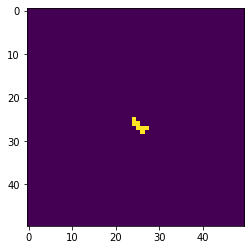

In [14]:
image = get_image(bbox, from_time, to_time, width, height, evalscript, data_collection, url, config)
plt.imshow(image, interpolation='none')

In [15]:
# We don't need to refine a bbox if we have the location of the volcano

# Process
# We try to find find the location of the volcano (mountain with the highest score)
#   - If location is found, that is the final lat/lng. Find exact date. If not found
#     just use event date and save the event anyway. Zoom can be fixed for all volcanoes.
#   - If location is not found, do the same as for the wildfires